<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/LabelPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import gdal
import matplotlib.pyplot as plt

http://www.grss-ieee.org/community/technical-committees/data-fusion/2021-ieee-grss-data-fusion-contest-track-msd/

In [ ]:
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif

--2020-12-11 02:58:39--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524021 (512K) [application/octet-stream]
Saving to: ‘2792_nlcd-2013.tif’

2792_nlcd-2013.tif  100%[===================>] 511.74K   374KB/s    in 1.4s    

2020-12-11 02:58:42 (374 KB/s) - ‘2792_nlcd-2013.tif’ saved [524021/524021]

--2020-12-11 02:58:42--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158 (513K) [application/octet-stream]

#Preprocessing of labels
NLCD data has pixel-wise labels, pixels takes on one of 15 values from FIGURE 1. 

1.The competition is interested grouping these into 4 classes (Water, Tree Canopy, Low Vegetation, Impervious).

2.The submission format expect 15 different class labels. (4x4 + unchanged) 

Eg. Water->Tree is its own label. Tree->Water is another.

2.For evaluatation, 8 kinds of changes are considered (gain/loss in the 2 classes)
These 8 changes are color coded for figures in any publication for this competition.

We need to 
* Map the 15 nlcd classes to the 4 target classes
* Compare before and after pixel classes and map before/after to one of the 15 labels
* Extract the changed pixed in before/after pictures and plot them in the correct color

This will help us with the evaluation of our algorithms and with processing the output of algorithms into the right format for submission.

In [ ]:
testlabel = gdal.Open("/content/2792_nlcd-2013.tif").ReadAsArray()

In [ ]:
batch_testlabel = np.expand_dims(testlabel, 0)

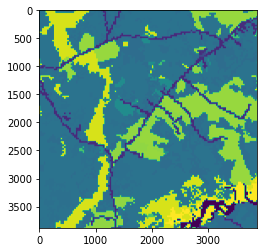

In [ ]:
plt.imshow(testlabel[:,:])

#Target Class label assignment


*   1: Water
*   2: Tree Canopy
*   3: Low Vegetaion
*   4: Imprevious

As a first step I'll assign the NLCD class label to the equivalent 1-4 class label according to the maximum probability in Figure 1. These likely a better way of doing this to be investigate a later time.



### ##Figure 1
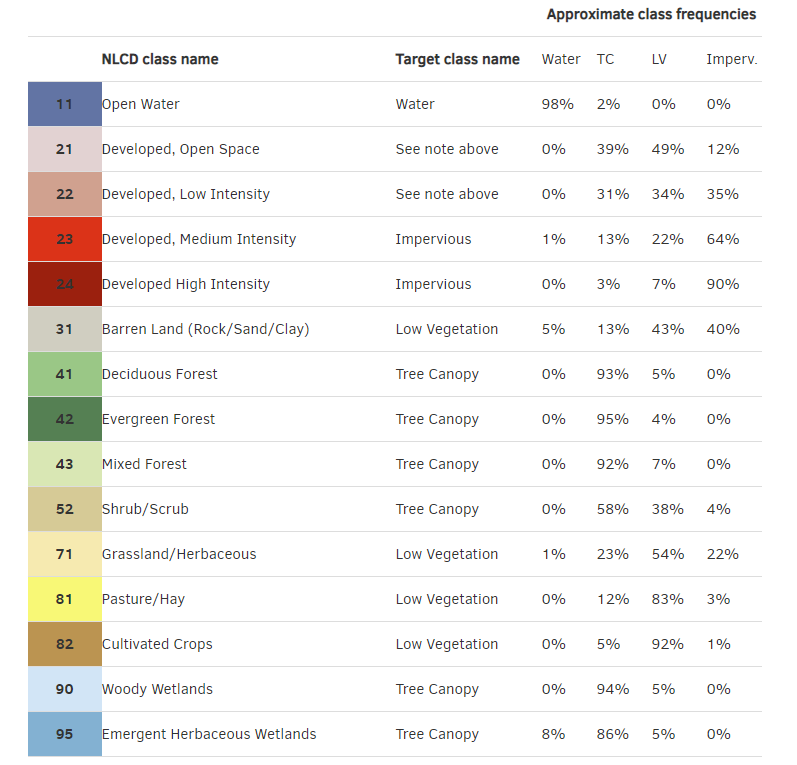

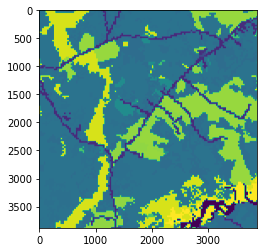

In [ ]:
plt.imshow(testlabel)

In [ ]:
labeldict={11:0,21:2,22:3,23:3,24:3,31:2,41:1,42:1,43:1,52:1,71:2,81:2,82:2,90:2,95:1}
targetdict={0:"Water",1:"Tree Canopy", 2:"Low Vegetation", 3:"Impervious"}

In [ ]:
newlabel = np.vectorize(labeldict.__getitem__)(testlabel) #Use vectorize instead of for loop, otherwise slow as hell.

In [ ]:
np.unique(newlabel)

array([0, 1, 2, 3])

In [ ]:
numclasses = 4
batch_testlabel = np.expand_dims(newlabel,axis=0) #expand axis for future batching of labels
oh_label = tf.one_hot(batch_testlabel,depth = numclasses,axis=-1)
tf.shape(oh_label)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([   1, 3880, 3880,    4], dtype=int32)>

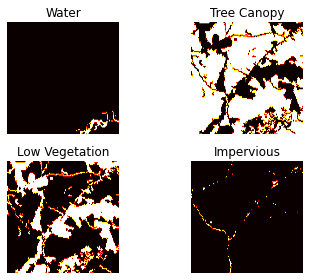

In [ ]:
fig, axs = plt.subplots(2, 2)
for i, subplot in enumerate(axs.flat):
  subplot.imshow(oh_label[0,:,:,i],cmap="hot")
  subplot.set_title(targetdict[i])
  subplot.axis("off")
fig.tight_layout()
plt.show()

##As functions

In [ ]:
def nlcd_to_target(batch_label):
    """
    Input:
    np.array or tf.tensor of shape (batch,Width,Height) corresponding to NLCD labeled data
    Returns:
    np.array of shape (batch,width,height)
    corresponding pixel level Target Class labels {0:"Water",1:"Tree Canopy", 2:"Low Vegetation", 3:"Impervious"}
    """
    labeldict={11:0,21:2,22:3,23:3,24:3,31:2,41:1,42:1,43:1,52:1,71:2,81:2,82:2,90:2,95:1}
    return np.vectorize(labeldict.__getitem__)(batch_label) 

In [ ]:
def nlcd_to_one_hot(batch_label, num_classes):
  """
  Input:
  np.array or tf.tensor of shape (batch,Width,Height) corresponding to NLCD labeled data
  Returns:
  np.array of shape (batch,width,height,4)
  corresponding to the one hot encoding at pixel level of Target Class {0:"Water",1:"Tree Canopy", 2:"Low Vegetation", 3:"Impervious"}
  """

  targetlabel = nlcd_to_target(batch_label)
  return tf.one_hot(targetlabel,depth = num_classes,axis=-1)

In [ ]:
def target_to_one_hot(batch_label, num_class):
  """
  Input: np.array or tf.tensor of shape (batch,Width,Height) corresponding to target label data
  Returns:
  np.array of shape (batch,width,height,4)
  corresponding to the one hot encoding at pixel level of Target Class {0:"Water",1:"Tree Canopy", 2:"Low Vegetation", 3:"Impervious"}
  """

  return tf.one_hot(targetlabel,depth = num_classes,axis=-1)

In [ ]:
nlcd2013 = gdal.Open("/content/2792_nlcd-2013.tif").ReadAsArray()
nlcd2016 = gdal.Open("/content/2792_nlcd-2016.tif").ReadAsArray()
labelsbefore = np.expand_dims(nlcd_to_one_hot(nlcd2013,4),axis=(0))
labelsafter = np.expand_dims(nlcd_to_one_hot(nlcd2016,4),axis=(0))

In [ ]:
testlabel2 = np.expand_dims(testlabel,axis=0)
oh_label2 = nlcd_to_one_hot(testlabel2,numclasses)

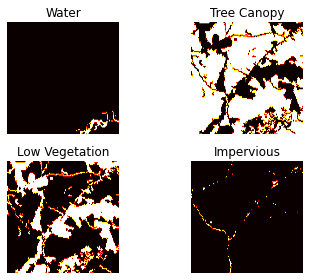

In [ ]:
fig, axs = plt.subplots(2, 2)
for i, subplot in enumerate(axs.flat):
  subplot.imshow(oh_label2[0,:,:,i],cmap="hot")
  subplot.axis("off")
  subplot.set_title(targetdict[i])

fig.tight_layout()
plt.show()

#Class change labelling
Map (4,4)>>(16) according to table

##Figure 2
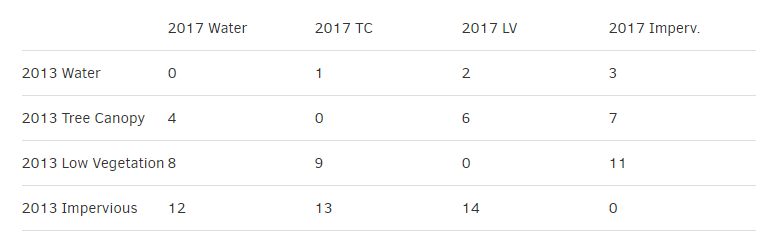

In [ ]:
np.shape(labelsbefore) #(batch,W,H,time)

(1, 3880, 3880, 4)

Not sure if a hadamard product or vectorized dict retrieval would be faster

In [ ]:
label_change_arr = np.array([[0,1,2,3],[4,0,6,7],[8,9,0,11],[12,13,14,0]])
np.matrix.view(label_change_arr)

array([[ 0,  1,  2,  3],
       [ 4,  0,  6,  7],
       [ 8,  9,  0, 11],
       [12, 13, 14,  0]])

In [ ]:
labels_combined = np.einsum("abcd,abce->abcde",labelsbefore,labelsafter)
print(np.shape(labels_combined))
print(labels_combined[0,1,1,:,:])

(1, 3880, 3880, 4, 4)
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [ ]:
class_change_label = labels_combined*label_change_arr #The last 2 dimensions is a 4x4 matrix with only 1 entry
class_change_label = np.sum(class_change_label, axis=(-1,-2)) #We collapse using a sum
np.shape(class_change_label)

(1, 3880, 3880)

In [ ]:
np.unique(class_change_label)

array([0., 1., 2., 6.])

In [ ]:
def make_label_change_dict():
  label_change_dict = {}
  i = 0
  for x in range(4):
    for y in range(4):
      label_change_dict[(x,y)] = i *(x!=y)
      i += 1
  return label_change_dict

label_change_dict = make_label_change_dict()
print(label_change_dict)

{(0, 0): 0, (0, 1): 1, (0, 2): 2, (0, 3): 3, (1, 0): 4, (1, 1): 0, (1, 2): 6, (1, 3): 7, (2, 0): 8, (2, 1): 9, (2, 2): 0, (2, 3): 11, (3, 0): 12, (3, 1): 13, (3, 2): 14, (3, 3): 0}


In [ ]:
#This dict retrieval is harder to implement, will do it some other time

## As function

In [ ]:
def get_class_change_label(before,after):
  """
  Input:
  two np.array or tf.tensor of shape (batch,Width,Height) corresponding to target class labeled data
  the arrays represent the before and after class labels for change detection
  Output:
  a np.array of shape (batch,Width,Height) corresponding to change labels (see figure 2)
  """
  label_change_arr = np.array([[0,1,2,3],[4,0,6,7],[8,9,0,11],[12,13,14,0]])
  labels_combined = np.einsum("abcd,abce->abcde",before,after)
  labels_combined = labels_combined*label_change_arr
  labels_combined = np.sum(labels_combined, axis=(-1,-2))
  return labels_combined

In [ ]:
np.unique(get_class_change_label(labelsbefore,labelsafter))

array([0., 1., 2., 6.])

##The competition expect the array to be uint8 and zipped.

#Gain/Loss label processing for figures
Map (4,4)>>(8), also assign correct colors

In [ ]:
from matplotlib import colors

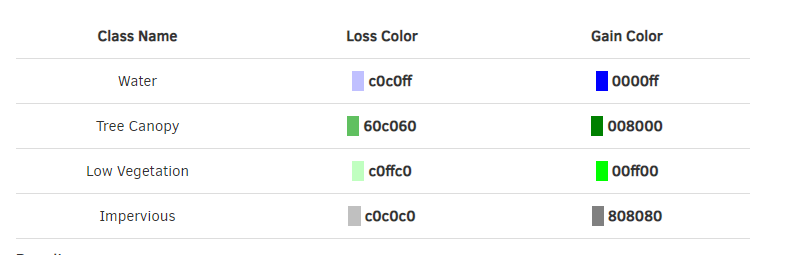

In [ ]:
target_class_difference = labelsbefore-labelsafter

In [ ]:
np.shape(target_class_difference)

(1, 3880, 3880, 4)

target_class_difference is of type (1,-1,0,0). 1 indicating that this class was lost, and turned into the class indexed by -1. 0 indicates no change

eg. for this example, Water turned to Tree Canopy

In [ ]:
gainlossbefore = (target_class_difference == 1)
gainlossafter = (target_class_difference == -1)
#These are the pixels that changed in both years

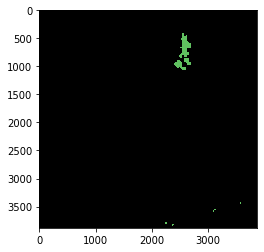

In [ ]:
mycmap = colors.ListedColormap(['black', '#60c060'])
plt.imshow(gainlossbefore[0,:,:,1],cmap=mycmap)

In [ ]:
color_dict = {0:("#c0c0ff","#0000ff"), 1:("#60c060","#008000"), 2: ("#c0ffc0","#00ff00"), 3:("#c0c0c0","#808080")}
before_after = (gainlossbefore,gainlossafter)


In [ ]:
"""
fig, ax = plt.subplots(nrows=4, ncols=2)

for i,row in enumerate(ax):
    for j,col in enumerate(row):
        col.imshow(before_after[j][0,:,:,i])"""

'\nfig, ax = plt.subplots(nrows=4, ncols=2)\n\nfor i,row in enumerate(ax):\n    for j,col in enumerate(row):\n        col.imshow(before_after[j][0,:,:,i])'

Water Loss/Gain


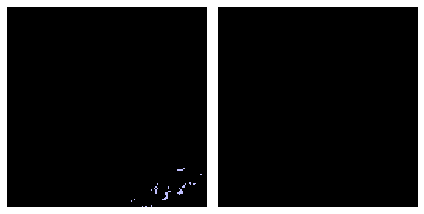

In [ ]:
print("Water Loss/Gain")
k=0
fig, ax = plt.subplots(1,2)
for i, col in enumerate(ax):
  mycmap = colors.ListedColormap(['black', color_dict[k][i]])
  col.imshow(before_after[i][0,:,:,k],cmap=mycmap)
  col.axis("off")
fig.tight_layout()
plt.show()

In [ ]:
def plot_loss_gain(k):
  fig, ax = plt.subplots(1,2)
  for i, col in enumerate(ax):
    mycmap = colors.ListedColormap(['black', color_dict[k][i]])
    col.imshow(before_after[i][0,:,:,k],cmap=mycmap)
    col.axis("off")
  fig.tight_layout()
  plt.show()

Tree Canopy Loss/Gain


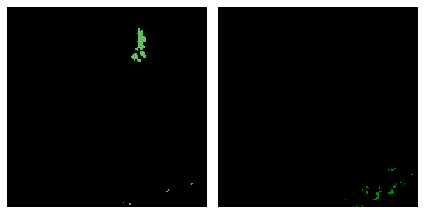

In [ ]:
print("Tree Canopy Loss/Gain")
plot_loss_gain(1)

Low Vegataion Loss/Gain


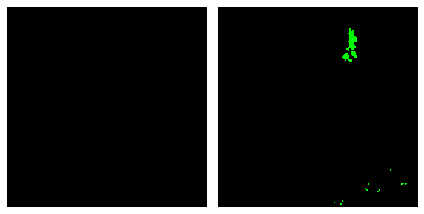

In [ ]:
print("Low Vegataion Loss/Gain")

plot_loss_gain(2)

Impervious Loss/Gain


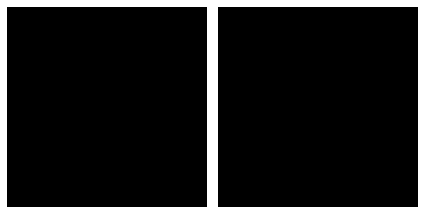

In [ ]:
print("Impervious Loss/Gain")
plot_loss_gain(3)

From this particular example: 
* some water became tree canopy + low vegetation
* some tree canopy became low vegetaion

We can look at rgb images

In [ ]:
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2013/2792_naip-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2017/2792_naip-2017.tif #The stupid naip-2792 2016 doesn't exist

--2020-12-11 02:59:51--  https://dfc2021.blob.core.windows.net/competition-data/naip-2013/2792_naip-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57758915 (55M) [application/octet-stream]
Saving to: ‘2792_naip-2013.tif.1’

2792_naip-2013.tif. 100%[===================>]  55.08M  9.74MB/s    in 9.6s    

2020-12-11 03:00:02 (5.75 MB/s) - ‘2792_naip-2013.tif.1’ saved [57758915/57758915]

--2020-12-11 03:00:02--  https://dfc2021.blob.core.windows.net/competition-data/naip-2017/2792_naip-2017.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60474233 (58M) [application/oc

In [ ]:
def get_arrays_naip(naip_path):
  naip = gdal.Open(naip_path).ReadAsArray().transpose([1,2,0])
  return naip[:,:,0:3],naip[:,:,3]

In [ ]:
naip2013rgb,_ = get_arrays_naip("/content/2792_naip-2013.tif")
naip2017rgb,_ = get_arrays_naip("/content/2792_naip-2017.tif") 

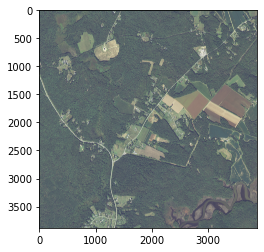

In [ ]:
plt.imshow(naip2013rgb)

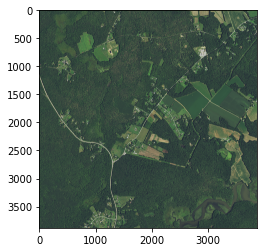

In [ ]:
plt.imshow(naip2017rgb)